# Assignment 2: Solving Steady State Khan & Thomas (2008)
## Economics 38001: Applied Macroeconomics
### Author: Levi Crews

This assignment serves as an introduction to numerically solving heterogeneous firm models. I will analyze a simple steady state version of Khan & Thomas' (2008) model with idiosyncratic shocks and fixed capital adjustment costs:

**Firms.** There is fixed unit mass of firms $j \in [0,1]$. Each firm has access to a decreasing returns to scale production function $y_{jt} = \epsilon_{jt} k_{jt}^{\theta} n_{jt}^{\nu}$, where
+ $y_{jt}$ is output
+ $\epsilon_{jt}$ is the idiosyncratic productivity of firm $j$
+ $k_{jt}$ is the capital stock of firm $j$
+ $n_{jt}$ is the labor input of firm $j$

and $\theta + \nu < 1$. Firms accumulate capital according to the accumulation equation $k_{jt+1} = (1-\delta) k_{jt} + i_{jt}$. If $|i_{jt}/k_{jt}| > 0.05$, the firm must pay a fixed cost $\xi$ in units of labor. 

**Households.** There is a representative household with preferences over consumption $C_t$ and labor supply $N_t$ represented by the expected utility function $E_0 \sum_{t=0}^{\infty} \beta^t (log C_t - a N_t)$. 

**Market clearing.** Output can be used for consumption or investment: $Y_t = C_t + I_t$ with $I_t = \int_0^1 i_{jt} dj$.

**Shock process and parameterization.** We assume that idiosyncratic shocks follow a simple two-state Markov process. In particular, $\epsilon \in \{\epsilon_L, \epsilon_H\} = \{0.8, 1.2\}$. Assume that 
+ Pr$(\epsilon'=\epsilon_H | \epsilon = \epsilon_L) = 0.25$,
+ Pr$(\epsilon'=\epsilon_L | \epsilon = \epsilon_H) = 0.25$.

The remaining parameters are
+ $\theta = 0.21$
+ $\nu = 0.64$
+ $\delta = 0.1$
+ $\beta = 0.96$
+ $\xi = 0.01$

In [1]:
# Setup
using Plots, QuantEcon, Random
using Distributions, LinearAlgebra, Statistics
using Roots

In [2]:
# Load user-defined functions
# Change path as needed
include("C:\\Users\\levic\\Dropbox\\University-of-Chicago\\Academics\\2-SecondYear\\Econ38001_AppliedMacro\\Assignment2-KhanThomas\\Crews_Econ38001_ValueFuncIter.jl")
include("C:\\Users\\levic\\Dropbox\\University-of-Chicago\\Academics\\2-SecondYear\\Econ38001_AppliedMacro\\Assignment2-KhanThomas\\Crews_Econ38001_DecisionRules.jl")
include("C:\\Users\\levic\\Dropbox\\University-of-Chicago\\Academics\\2-SecondYear\\Econ38001_AppliedMacro\\Assignment2-KhanThomas\\Crews_Econ38001_StationaryDist.jl")
include("C:\\Users\\levic\\Dropbox\\University-of-Chicago\\Academics\\2-SecondYear\\Econ38001_AppliedMacro\\Assignment2-KhanThomas\\Crews_Econ38001_LaborDemand.jl");

In [3]:
# Initialize parameters
epsilon_H = 1.2
epsilon_L = 0.8
p_HH = 0.75
p_LL = 0.75
theta = 0.21
nu = 0.64
delta = 0.1
beta = 0.96
xi = 0.01
thresh = 0.05;

### Solving the Representative Agent Steady State

Consider a representative firm with the production function specified above and productivity $E_{\psi}[\epsilon_{jt}]$, where $\psi$ is the stationary distribution of $\epsilon_{jt}$. Assume the representative firm rents capital and labor in competitive input markets as in the RBC model from Topic 0. I will compute the steady state capital stock $K_{rep}^{*}$ and steady state wage $w_{rep}^{*}$ of the representative agent model. In doing so, I assume that steady state labor supply is $N_{rep}^{*} = 0.6$.

In [4]:
# Compute stationary distribution
P = [p_LL 1-p_LL; 1-p_HH p_HH]
mc = MarkovChain(P)
psi = stationary_distributions(mc)[1,1]
Eps = [epsilon_L, epsilon_H]
epsilon = dot(psi, Eps)
println("The stationary distribution is ", psi)
println("Expected productivity is ", epsilon)

The stationary distribution is [0.5, 0.5]
Expected productivity is 1.0


Because we have a representative firm and household, we can solve the problem of the social planner to find the steady state capital stock. The relevant Bellman equation is
$$
v(k) = \max_{k'} \log [k^{\theta} n^{\nu} + (1-\delta)k - k'] + \beta v(k')
$$
The first-order condition is 
$$
\beta v'(k') = \frac{1}{k^{\theta} n^{\nu} + (1-\delta)k - k'},
$$
and the envelope condition is
$$
v'(k) = \frac{\theta k^{\theta-1} n^{\nu} + 1 - \delta}{k^{\theta} n^{\nu} + (1-\delta)k - k'}.
$$
Imposing steady state $k = k'$ yields
$$
\frac{1}{\beta} = \theta k^{\theta-1} n^{\nu} + 1 - \delta,
$$
which implies
$$
k_{rep}^{*} = \left(\frac{1 - \beta + \beta \delta}{\beta \theta n^{\nu}} \right)^{1/(\theta-1)}.
$$
The implied steady-state wage is just the marginal product of labor evaluated at the steady-state capital stock:
$$
w_{rep}^{*} = \nu (k_{rep}^{*})^{\theta} n^{\nu-1}.
$$

In [5]:
n = 0.6
k_rep_star = ((1 - beta + beta*delta) / (beta*theta* n^nu))^(1/(theta-1))
y_rep_star = k_rep_star^theta * n^nu
w_rep_star = nu*y_rep_star/n
println("Steady state capital is ", k_rep_star)
println("Steady state wage is ", w_rep_star)

Steady state capital is 1.0881001887382777
Steady state wage is 0.7829715643830996


### Solving the Individual Decision Problem

In the steady state recursive competitive equilibrium of the full model, the Bellman equation describing firm optimization is given by
$$
v(\epsilon,k) = max_{k',n} [\epsilon k^{\theta} n^{\nu} - w^{*}n - (k' - (1-\delta)k) - 1_{\{|k' - (1-\delta) k| > 0.05 k\}}\xi w^{*} + \beta E(v(\epsilon', k'))]
$$
where $w^{*}$ is the steady state real wage. In this section I will solve this dynamic programming problem using discretized value function iteration. For now, I set $w^{*} = w_{rep}^{*}$. In the next section I will solve for the true steady state wage that clears the labor market.

#### Discretization of the value function domain

Assume that the capital stock $k$ takes on values in a discrete grid $K = (k_1, \ldots, k_N)$ where $k_i > k_{i-1}$ and $N$ is the total number of grid points. Under this assumption, the value function $v(\epsilon, k)$ can be represented by a $2 \times N$ matrix. I set $N=400$, $k_1 = 0.2 k_{rep}^{*}$, and $k_N = 3.75 k_{rep}^{*}$. Note that my grid is therefore wider than that initially suggested by Prof. Winberry.

In [6]:
# Set wage
w = w_rep_star

# Discrete grid of capital stock values
N = 400
lo = 0.2
hi = 3.75
k_1 = lo * k_rep_star
k_N = hi * k_rep_star
kgrid = range(k_1, k_N, length=N)'

# Define some useful matrices
K = repeat(kgrid, 2)
E = repeat(Eps, 1, N);

#### Constructing the profit matrix

I will iterate on the Bellman equation written above. To that end, I will first construct a matrix $\Pi$ whose $(i,j)$ entry is 
$$
\pi(\epsilon_i, k_j) = \max_n \epsilon_i k_j^{\theta} n^{\nu} - w^{*} n,
$$
or, in closed form,
$$
\pi(\epsilon_i, k_j) = \epsilon_i k_j^{\theta} [\nu \epsilon_i k_j^{\theta} / w^{*}]^{\nu/(1-\nu)} - w^{*} [\nu \epsilon_i k_j^{\theta} / w^{*}]^{1/(1-\nu)}.
$$

In [7]:
Pi = ((nu/w) * E .* K .^(theta)).^(nu/(1-nu)) .* (E .* K .^(theta)) - w*((nu/w) * E .* K .^(theta)).^(1/(1-nu));

#### Computing the value function by iteration

I will now compute the value function by iteration. To do so, I call my user-defined function (filed in this GitHub repository) repeatedly, each time generating a new iteration of the value and policy functions discretized over the grid. Because the Bellman equation is a contraction, the Contraction Mapping Theorem ensures that this procedure will converge to the true value and policy functions. I set an error bound of $10^{-6}$ in order to keep the total number of iterations small.

In [8]:
# Because I'll use Cartesian indices, the following matrix will be helpful
K3 = zeros(2, N, N)
for k = 1:N
    K3[:,k,:] = K
end

In [9]:
# Initialize =while= loop
V_0 = Pi
err = 100
bound = 10^(-6)
iter = 0

V_1, H_1 = Crews_Econ38001_ValueFuncIter(V_0, Pi, E, K3, beta, delta, xi, thresh, p_LL, p_HH, w);

In [10]:
# =while= loop
V_n1 = V_1
while err > bound
    iter += 1
    V_n2, H = Crews_Econ38001_ValueFuncIter(V_n1, Pi, E, K3, beta, delta, xi, thresh, p_LL, p_HH, w)
    V_n = V_n1
    V_n1 = V_n2
    err = maximum(abs.(V_n1 - V_n))
end
println("The value function took ", iter, " iterations to converge")
println("The error is approximately ", err)

The value function took 293 iterations to converge
The error is approximately 9.915067025190183e-7


#### Plotting the value and policy functions

I will now plot the value and policy functions. In order to keep the figures two-dimensional, I plot the functions separately for the low- and high-TFP states.

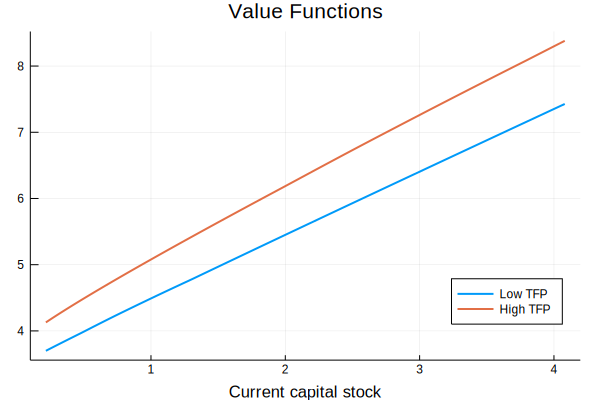

In [11]:
plot(K[1,:], [V_n1[1,:], V_n1[2,:]], title="Value Functions",xlabel="Current capital stock", label=["Low TFP" "High TFP"],lw=2,legend=:bottomright)

In [12]:
H = Crews_Econ38001_ValueFuncIter(V_n1, Pi, E, K3, beta, delta, xi, thresh, p_LL, p_HH, w)[2];

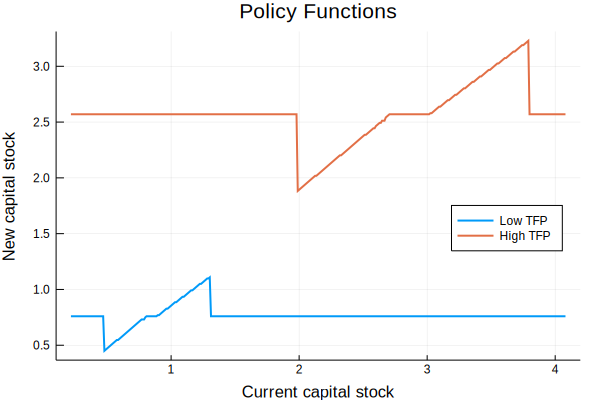

In [13]:
plot(K[1,:], [H[1,:], H[2,:]], title="Policy Functions",
    xlabel="Current capital stock",
    ylabel="New capital stock",
    label=["Low TFP" "High TFP"],
    lw=2,
    legend=:right)

The grid bounds were set to ensure that the full shape of both policy functions could be seen in this figure.

### Computing the Stationary Distribution

I will now compute the stationary distribution associated with the decision rules from the preceding section. In particular, I will approximate the stationary distribution with a probability mass function $g(\epsilon_i, k_j)$ over the discretized space. This function must satisfy the law of motion
$$
g(\epsilon_k, k_{\ell}) = \sum_{i = L,H} \sum_{j=1}^N Pr(\epsilon' = \epsilon_k | \epsilon = \epsilon_i) 1_{\{H_{ij} = k_{\ell}\}} g(\epsilon_i, k_j),
$$
where $H$ is the policy rule from the preceding section. Let $G$ be a $2 \times N$ matrix with $(i,j)$ entry $g(\epsilon_i, k_j)$. Let $g$ be the $2N \times 1$ vector representation of this matrix, i.e., `g=reshape(G, 2*N, 1)`.

#### Constructing the transition matrix

I will pursue an iterative strategy to computing $g$. A key input into this strategy will be a $2N \times 2N$ transition matrix $T$ such that the stationary distribution $g$ satisfies $g = Tg$. Hence, the entries in $T$ correspond to the terms in the summation of the displayed equation in the immediately preceding cell. I will now construct this matrix.

In [16]:
# Julia, unlike Matlab, is actually quite fast at loops!
# Construct indicator matrix
IndicG = zeros(2,N,2,N)
@time begin
    for i = 1:2
        for j = 1:N
            for k = 1:2
                for l = 1:N
                    if H[k,l] == K[i,j]
                        IndicG[i,j,k,l] = 1
                    end
                end
            end
        end
    end
end

  0.166994 seconds (1.93 M allocations: 39.282 MiB, 5.43% gc time)


In [19]:
# Construct probability matrix
Prob = zeros(2,N,2,N)
@time begin
    for i = 1:2
        for j = 1:N
            for k = 1:2
                for l = 1:N
                    if i == 1 && k == 1
                        Prob[i,j,k,l] = p_LL
                    elseif i == 2 && k == 1
                        Prob[i,j,k,l] = (1.0 - p_LL)
                    elseif i == 1 && k == 2
                        Prob[i,j,k,l] = (1.0 - p_HH)
                    else
                        Prob[i,j,k,l] = p_HH
                    end
                end
            end
        end
    end
end

  0.681926 seconds (2.88 M allocations: 83.081 MiB, 2.69% gc time)


In [20]:
# Reshape
IndicG = reshape(IndicG, 2*N, 2*N)
Prob = reshape(Prob, 2*N, 2*N)

# Multiply elementwise to get =T=
T = IndicG .* Prob;

In [22]:
# Initialize iteration
g_0 = repeat([1/(2*N)], 2*N, 1)
iterg = 0
g_n = g_0;

In [23]:
# Iterate to get stationary =g=
while err > bound*10^(-10)
    iterg += 1
    g_n1 = T * g_n
    err = maximum(abs.(g_n1 - g_n))
    g_n = g_n1
end
println("The distribution took ", iterg, " iterations to converge")

The distribution took 125 iterations to converge


In [24]:
G = reshape(g_n, 2, N);

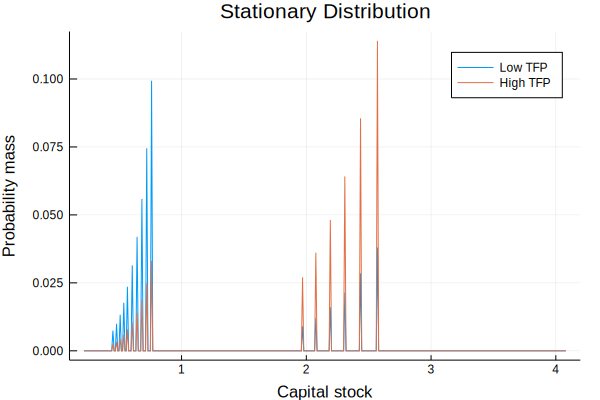

In [25]:
plot(K[1,:], [G[1,:], G[2,:]], title="Stationary Distribution",
    xlabel="Capital stock",
    ylabel="Probability mass",
    label=["Low TFP" "High TFP"],lw=1)

### Compute Steady State Equilibrium

So far I have been using $w_{rep}^{*}$ as a guess of the wage. I will now solve for the equilibrium value of the wage using a version of the Hopenhayn-Rogerson algorithm discussed in class. 
1. Compute the wage $w^{*}$ such that aggregate labor demand $N^d(w^{*}) = 0.6$. 
2. Given this wage value, use the household's first-order condition to back out the parameter $a$ that ensures aggregate labor supply equals aggregate labor demand: $N^s(w^{*}) = 0.6$

#### Computing labor demand given a wage

I have written a user-defined function `Crews_Econ38001_LaborDemand` that takes as input a guess of the steady-state wage and outputs the corresponding aggregate labor demand. The function performs the following steps.
1. Given a wage $w$, it computes individual decision rules as in Section 1.
2. Given decision rules, it computes the stationary distribution as in Section 2.
3. Given the stationary distribution, it computes aggregate labor demand. Letting $n(\epsilon_i, k_j)$ denote the labor demand (sum of labor used in production and to pay the fixed cost) of a firm with individual state $(\epsilon_i, k_j)$, aggregate labor demand is
$$
N = \sum_{i = L,H} \sum_{j=1}^N n(\epsilon_i, k_j) g(\epsilon_i, k_j).
$$

With this function in hand, I find the steady state wage by solving
$$
N^d(w^{*}) - 0.6 = 0
$$
using Julia's `NLsolve` routine with $w_{rep}^{*}$ as my initial guess.

In [26]:
function f(x)
    Crews_Econ38001_LaborDemand(x, E, K, theta, nu, beta, delta, xi, thresh, p_LL, p_HH) - 0.6
end
f(w_rep_star)

0.23594876175262092

In [27]:
@time begin
    w_star = find_zero(f, (0.7, 0.9), Bisection())
end
println("The equilibrium wage is \$w^{*}\$ = ", w_star)

318.767880 seconds (153.60 M allocations: 46.031 GiB, 4.16% gc time)
The equilibrium wage is $w^{*}$ = 0.833537160197604


The equilibrium wage $w^{*} = 0.834$ is **larger** than $w_{rep}^{*} = 0.783$. Note: the solver takes much longer than I'd like, but I have not had the time to explore all of the nonlinear solvers that Julia has, so this will have to do for now.

#### Finding the disutility of labor supply

The household's first-order condition for labor is $w^{*} /C = a$, where $C$ is aggregate consumption. I compute aggregate consumption using the resource constraint $C = Y-I$, where $Y$ and $I$ are computed by integrating firms' output and investment decisions against the stationary distribution, respectively.

In [28]:
# Equilibrium policy function and stationary distribution
H_star = Crews_Econ38001_DecisionRules(w_star, E, K, theta, nu, beta, delta, xi, thresh, p_LL, p_HH)[1]
G_star = Crews_Econ38001_StationaryDist(H_star, p_LL, p_HH)

# Construct aggregate consumption
n_d = ((nu/w_star) * E .* K .^(theta)).^(1/(1-nu))   # firm labor demand
y = E .* K.^(theta) .* n_d.^(nu)    # firm output
invest = H_star .- (1-delta)*K    # firm investment

c = y .- invest
C_temp = c * G_star'
C = C_temp[1,1] + C_temp[2,2]     # aggregate consumption

a = w_star / C   # implied disutility of labor

println("The implied value of \$a\$ is ", a)

The implied value of $a$ is 1.270556214831988
